In [2]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.circuit.library import QFT, GroverOperator

from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory

import math
import numpy as np
import matplotlib.pyplot as plt

In [123]:
evaluation_qubits = 3

probability = 0.3
theta = 2 * np.arcsin(np.sqrt(probability))

evaluation_registry = QuantumRegister(evaluation_qubits, 'evaluation')
a_registry = QuantumRegister(1, 'q')

## First with the Qiskit function

In [124]:
a_factory =  QuantumCircuit(a_registry)
a_factory.ry(theta, a_registry[0])
backend = Aer.get_backend('statevector_simulator')
job = execute(a_factory, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

{'0': 0.7, '1': 0.3}


In [125]:
ae = AmplitudeEstimation(evaluation_qubits, a_factory)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'))

In [126]:
result

{'a_estimation': 0.1464466, 'confidence_interval': [0.2890625979732687, 0.30152171324824617], 'estimation': 0.1464466, 'num_oracle_queries': 7168, 'ml_value': 0.2952673024591361, 'mapped_a_samples': [0.0, 0.1464466, 0.5, 0.8535534, 1.0], 'probabilities': [0.0478515625, 0.49609375, 0.3671875, 0.068359375, 0.0205078125], 'shots': 1024, 'mle': 0.2952673024591361, 'circuit_result': {'000': 49, '001': 21, '010': 198, '011': 178, '100': 244, '101': 32, '110': 38, '111': 264}, 'a_samples': [(0.0, 0.0478515625), (0.1464466, 0.49609375), (0.5, 0.3671875), (0.8535534, 0.068359375), (1.0, 0.0205078125)], 'y_measurements': [(0, 0.0478515625), (1, 0.23828125), (2, 0.193359375), (3, 0.037109375), (4, 0.0205078125), (5, 0.03125), (6, 0.173828125), (7, 0.2578125)], 'mapped_values': [0.0, 0.1464466, 0.5, 0.8535534, 1.0], 'max_probability': 0.49609375}

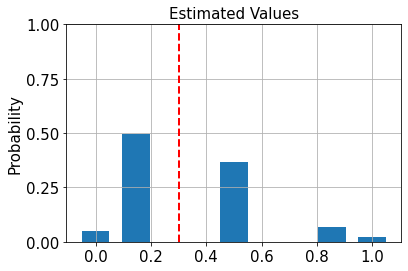

In [127]:
# plot estimated values
plt.bar(result['mapped_a_samples'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

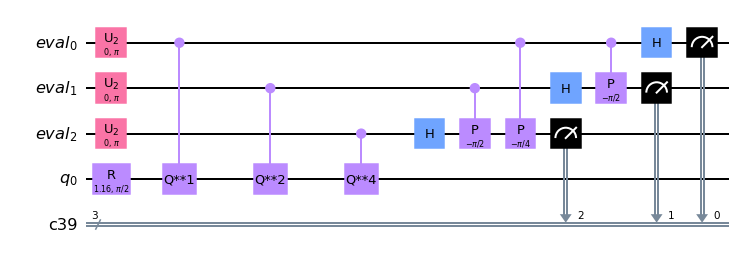

In [128]:
ae._circuit.decompose().draw('mpl')

Q Operator

$$ \mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f, $$

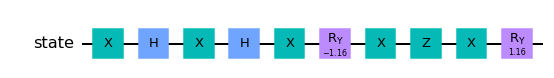

In [136]:
ae.grover_operator.draw('mpl')

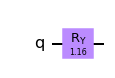

In [133]:
ae.state_preparation.draw('mpl')

## Design our own AE

In [137]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)



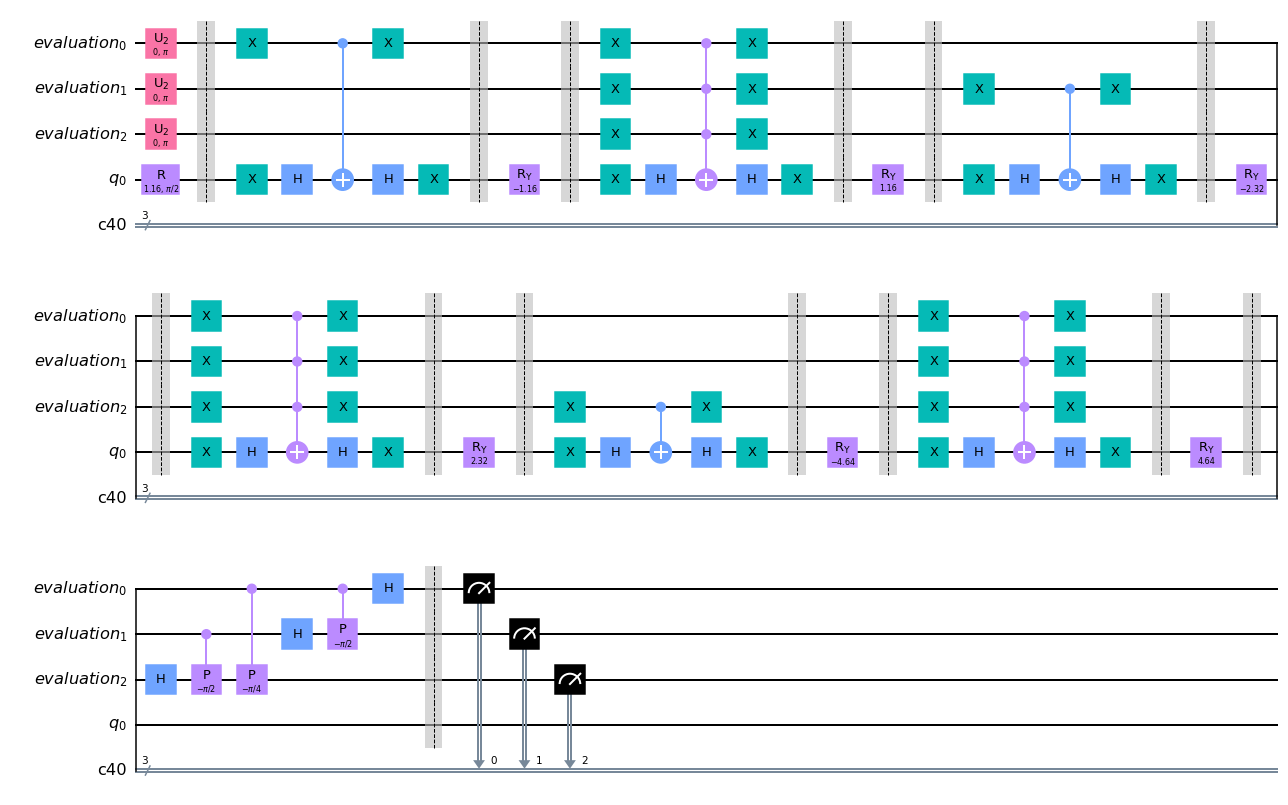

In [138]:
cr = ClassicalRegister(evaluation_qubits)
qc = QuantumCircuit(evaluation_registry, a_registry, cr)

#qc.append(a_operator(), a_registry)

# A
qc.ry(theta, a_registry)

qc.h(range(evaluation_qubits))
qc.barrier()
#Do the controlled-U operations:
# 𝑄=𝐴𝑆0𝐴−1𝑆𝜓0
repetitions = 1
for counting_qubit in range(evaluation_qubits):
    
    oracle = QuantumCircuit(evaluation_qubits+1)
    oracle.x([counting_qubit, evaluation_qubits])
    oracle.h(evaluation_qubits)
    oracle.cx(counting_qubit, evaluation_qubits)
    oracle.h(evaluation_qubits)
    oracle.x([counting_qubit, evaluation_qubits])
    
    state_preparation = QuantumCircuit(evaluation_qubits+1)
    state_preparation.ry(theta*repetitions, evaluation_qubits)

    reflection_qubits = [0,4]
    
    grover_op = GroverOperator(oracle, state_preparation, insert_barriers=True)
    
    qc.append(grover_op, range(evaluation_qubits+1))
    
    
    # Another try
    # A
    #qc.u3(theta*repetitions,0,0, evaluation_qubits); 
    
    # S0
    #qc.x(evaluation_qubits)
    #qc.z(evaluation_qubits) 
    #qc.x(evaluation_qubits)
    
    # A-1
    #qc.u3(-theta*repetitions,0,0, evaluation_qubits); 
    
    # Spsi0
    #qc.x(evaluation_qubits)
    #qc.h(evaluation_qubits)
    #qc.cx(counting_qubit, evaluation_qubits)
    #qc.h(evaluation_qubits)
    #qc.x(evaluation_qubits)
    
    qc.barrier()
    repetitions *= 2


#qft_dagger(qc, evaluation_qubits)
qc.append(QFT(evaluation_qubits, inverse=True, do_swaps=False), range(evaluation_qubits))
qc.barrier()
qc.measure(range(evaluation_qubits), cr)
qc.decompose().draw('mpl')

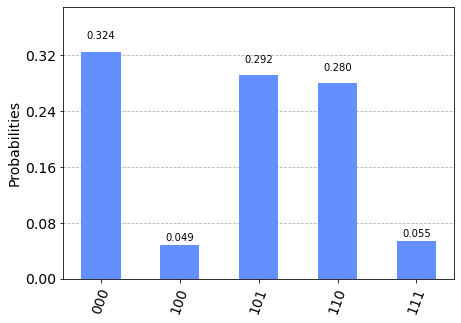

In [139]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()

plot_histogram(counts)

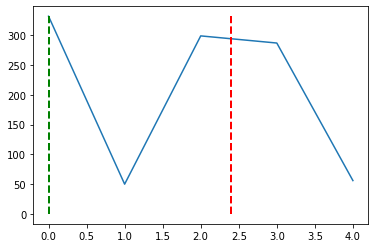

In [140]:
plt.plot(counts.values())
# Real (Red)
plt.plot([probability * 2**evaluation_qubits, probability * 2**evaluation_qubits], [0,max(counts.values())], 'r--', linewidth=2)
# Calculated (Green)
plt.plot([int(max(counts, key=counts.get),2), int(max(counts, key=counts.get),2)], [0,max(counts.values())], 'g--', linewidth=2)
plt.show()

In [141]:
print("Most probably state: ", max(counts, key=counts.get), "-- ", int(max(counts, key=counts.get),2))
estimated_probability = int(max(counts, key=counts.get),2) / 2**evaluation_qubits
print("Estimated Probability: theta = state / 2^n :", estimated_probability)
print("Real Probability: ", probability)
print("Error: ", estimated_probability - probability)

Most probably state:  000 --  0
Estimated Probability: theta = state / 2^n : 0.0
Real Probability:  0.3
Error:  -0.3


In [142]:
for i in counts:
    estimated_probability = int(i,2) / 2**evaluation_qubits
    print(i, " : ", counts[i], " - ", estimated_probability)

000  :  332  -  0.0
100  :  50  -  0.5
101  :  299  -  0.625
110  :  287  -  0.75
111  :  56  -  0.875


Grover operator examples

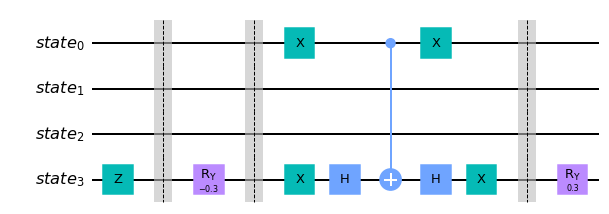

In [143]:
oracle = QuantumCircuit(4)
oracle.z(3)
reflection_qubits = [0, 3]
state_preparation = QuantumCircuit(4)
state_preparation.ry(0.3, 3)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=reflection_qubits, insert_barriers=True)
grover_op.draw('mpl')

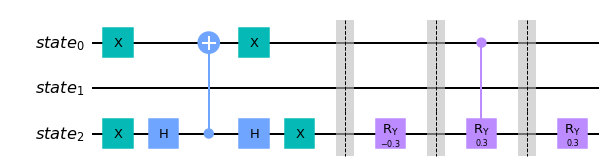

In [144]:
state_preparation = QuantumCircuit(3)

oracle = QuantumCircuit(3)
oracle.x([2,0])
oracle.h(2)
oracle.mcx([2],0)
oracle.h(2)
oracle.x([2,0])

zero_reflection = QuantumCircuit(3)
zero_reflection.cry(0.3, 0, 2)

state_preparation.ry(0.3, 2)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=[0,3], zero_reflection=zero_reflection, insert_barriers=True)
grover_op.draw('mpl')